In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io

%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

In [2]:
OVERWRITE = False  # set to True if you want to refit the models
np.random.seed(42)

In [3]:
color_palette = {
 'Color': 'tab:orange', 
 'Orientation': 'tab:purple',
 }

In [4]:
experiment_name = 'B01'
data_dir = './data'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
eyefiles = sorted(list(exp.data_dir.glob('*eyedata*.mat')))

In [5]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 100
group_dict = OrderedDict([('SS1_col',[11]),('SS2_col',[13]), ('SS1_ori',[21]),('SS2_ori',[23])])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # same order as above

In [10]:
def train_model_on_subset(training_labels, subtitle, default_bad_eyes=[]):
    wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
    clfr = eeg_decoder.Classification(wrangl,exp.nsub)
    clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

    if OVERWRITE:
        bad_eye_subs = []
        for isub in range(exp.nsub):

            print(isub)
            xdata_eeg,ydata = exp.load_eeg(isub)
            eyedata = io.loadmat(eyefiles[isub])['eyedata']
            eyedata = np.rollaxis(eyedata, -1)  # reorder to trial, feat, time
            try:
                xdata = np.concatenate([xdata_eeg,eyedata],axis=1)  # combine eyedata so it goes along for the ride
            except:
                bad_eye_subs.append(isub)
                xdata = xdata_eeg

            xdata,ydata = wrangl.group_labels(xdata,ydata)

            for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata, train_labels=training_labels):

                X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)

                if wrangl.ifold < 3: # see what counts we are getting for our training/testing data after balancing.
                    print(np.unique(y_train, return_counts=True))
                    print(np.unique(y_test, return_counts=True))
                
                # shuffle test labels within condition
                train_col = (y_test==0) | (y_test==1)
                train_mot = (y_test==2) | (y_test==3)
                y_test_shuffle = np.full(y_test.shape, np.nan)
                y_test_shuffle[train_col] = np.random.permutation(y_test[train_col])
                y_test_shuffle[train_mot] = np.random.permutation(y_test[train_mot])

                for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    # separate EEG and eye data
                    X_train_eeg = X_train[:, :30]
                    X_test_eeg = X_test[:, :30]
                    clfr.decode(X_train_eeg,X_test_eeg,y_train,y_test,y_test_shuffle,isub)
                    if X_train.shape[1] > 30:  # if they have eye data
                        X_train_eye = X_train[:, 30:]
                        X_test_eye = X_test[:, 30:]
                        clfr_eyes.decode(X_train_eye,X_test_eye,y_train,y_test,y_test_shuffle,isub)

        interp = eeg_decoder.Interpreter(clfr, subtitle=subtitle) 
        interp.save_results(timestamp=False)

        interp_eyes = eeg_decoder.Interpreter(clfr_eyes, subtitle=subtitle+'_eyes')
        interp_eyes.save_results(timestamp=False)
        print(bad_eye_subs)
    else:
        bad_eye_subs = default_bad_eyes

    return bad_eye_subs

In [7]:
def interpret_results(subtitle, condition_names, condition_order, bad_eye_subs=None, stim_time=[0, 250], ylim = [-1, 3], savefig=True):
    interp = eeg_decoder.Interpreter()
    interp.load_results(subtitle)

    if bad_eye_subs is not None:
        interp.confidence_scores = np.delete(interp.confidence_scores, bad_eye_subs, axis=0)
        interp.confidence_scores_shuff = np.delete(interp.confidence_scores_shuff, bad_eye_subs, axis=0)

    # plot hyperplane results for visual check
    # interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    interp.plot_hyperplane(
        stim_time=[0,250],
        ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
        savefig=False,subtitle='Blank',legend_pos='lower left')
    plt.show()
    plt.close()
    

    # get the contrast scores for plotting and testing them
    cond1_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
    cond1_scores = np.mean(cond1_diff, axis=2)

    cond2_diff = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]  # SS2_mot - SS1_mot
    cond2_scores = np.mean(cond2_diff, axis=2)

    cond_scores = [cond1_scores, cond2_scores]
    cond_scores = [cond_scores[i] for i in condition_order]

    # shuffled scores
    cond1_diff_shuff = interp.confidence_scores_shuff[..., 1] - interp.confidence_scores_shuff[..., 0]  # SS2_col - SS1_col
    cond1_scores_shuff = np.mean(cond1_diff_shuff, axis=2)

    cond2_diff_shuff = interp.confidence_scores_shuff[..., 3] - interp.confidence_scores_shuff[..., 2]  # SS2_mot - SS1_mot
    cond2_scores_shuff = np.mean(cond2_diff_shuff, axis=2)

    shuff_scores = [cond1_scores_shuff, cond2_scores_shuff]
    shuff_scores = [shuff_scores[i] for i in condition_order]
    shuff_colors = ['lightgray', 'darkgray']

    # plot the scores
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)
    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")


    labels = [condition_names[i] for i in condition_order]
    for i, curr_scores in enumerate(cond_scores):

        mean, upper, lower = interp.get_plot_line(shuff_scores[i])
        ax.plot(interp.t, mean, shuff_colors[i], label=labels[i]+' (Shuffled)')
        ax.fill_between(interp.t, upper, lower, color=shuff_colors[i], alpha=0.5)

        mean, upper, lower = interp.get_plot_line(curr_scores)
        ax.plot(interp.t, mean, color_palette[labels[i]], label=labels[i])
        ax.fill_between(interp.t, upper, lower, color=color_palette[labels[i]], alpha=0.5)

        _, ps = sista.ttest_rel(curr_scores, shuff_scores[i], axis=0, alternative="greater")
        _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
        sig05 = corrected_p < 0.05
        plt.scatter(
            interp.t[sig05],
            np.ones(sum(sig05))*-.2*(i+1)-.3,
            marker="s",
            s=33,
            c=color_palette[labels[i]]
        )

    # compare the two
    __, ps = sista.ttest_rel(cond_scores[0]-cond_scores[1], shuff_scores[0]-shuff_scores[1], axis=0, alternative="greater")
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    if sum(sig05) > 0:
        _ = plt.scatter(
            interp.t[sig05],
            np.ones(sum(sig05))*-.9,
            marker="s",
            s=33,
            c="k",
        )
    else:
        print("no significant differences between conditions")

    plt.title(f'Hyperplane contrast: {subtitle}')
    _ = plt.legend()
    sns.despine()
    if savefig:
        plt.savefig(f'output/figures/{subtitle}_hyperplane.svg')
    plt.show()
    plt.close()

    return cond1_diff, cond2_diff

In [8]:
def correlate_contrasts(interp, cond_diff_eyes, cond_diff_eeg, condition_names, subtitle, stim_time=[0, 250], ylim = [-.1, .1], ylim_stds = [0, 2]):

    nsubs = cond_diff_eyes[0].shape[0]
    ntimes = cond_diff_eyes[0].shape[1]
    cond1_corrs = np.zeros((nsubs,ntimes))
    cond2_corrs = np.zeros((nsubs,ntimes))

    for isub in range(nsubs):
        for t in range(ntimes):
            # correlations are immediately Fisher transformed
            cond1_corrs[isub, t] = np.arctanh(np.corrcoef(cond_diff_eyes[0][isub, t], cond_diff_eeg[0][isub, t])[0, 1])
            cond2_corrs[isub, t] = np.arctanh(np.corrcoef(cond_diff_eyes[1][isub, t], cond_diff_eeg[1][isub, t])[0, 1])

    # plot correlations
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)


    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")

    labels = condition_names
    for i, curr_corrs in enumerate([cond1_corrs, cond2_corrs]):

        mean, upper, lower = interp.get_plot_line(curr_corrs)
        ax.plot(interp.t, mean, color_palette[labels[i]], label=labels[i])
        ax.fill_between(interp.t, upper, lower, color=color_palette[labels[i]], alpha=0.5)

        _, ps = sista.ttest_1samp(curr_corrs, popmean=0, axis=0, alternative="greater")
        _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
        sig05 = corrected_p < 0.05
        if sum(sig05):
            plt.scatter(
                interp.t[sig05],
                np.ones(sum(sig05))*-.02*(i+1)-.075,
                marker="s",
                s=33,
                c=color_palette[labels[i]]
            )
        else:
            print(f'no significant correlations for condition {labels[i]}')
        print(curr_corrs.mean(0)[interp.t > 250].mean(), np.tanh(curr_corrs.mean(0)[interp.t > 250].mean()))

    plt.title("Fisher's z of permutation contrasts between EEG and eye models")
    _ = plt.legend()
    sns.despine()
    plt.savefig(f'output/figures/corrs_{subtitle}.svg')
    plt.show()
    plt.close()

    # look at standard deviations across permutations
    cond1_std_eyes = np.zeros((nsubs,ntimes))
    cond1_stds_eeg = np.zeros((nsubs,ntimes))
    cond2_stds_eyes = np.zeros((nsubs,ntimes))
    cond2_stds_eeg = np.zeros((nsubs,ntimes))

    for isub in range(nsubs):
        for t in range(ntimes):
            cond1_std_eyes[isub, t] = np.std(cond_diff_eyes[0][isub, t])
            cond1_stds_eeg[isub, t] = np.std(cond_diff_eeg[0][isub, t])
            cond2_stds_eyes[isub, t] = np.std(cond_diff_eyes[1][isub, t])
            cond2_stds_eeg[isub, t] = np.std(cond_diff_eeg[1][isub, t])


    # convert to data frames
    cond1_std_eyes=pd.DataFrame(cond1_std_eyes).T
    cond1_std_eyes['time'] = interp.t
    cond1_std_eyes = cond1_std_eyes.melt(id_vars='time',var_name='subject',value_name="std")
    cond1_std_eyes['Test Condition'] = condition_names[0]
    cond1_std_eyes['Data Type'] = 'Eye'

    cond1_stds_eeg=pd.DataFrame(cond1_stds_eeg).T
    cond1_stds_eeg['time'] = interp.t
    cond1_stds_eeg = cond1_stds_eeg.melt(id_vars='time',var_name='subject',value_name="std")
    cond1_stds_eeg['Test Condition'] = condition_names[0]
    cond1_stds_eeg['Data Type'] = 'EEG'


    cond2_stds_eyes=pd.DataFrame(cond2_stds_eyes).T
    cond2_stds_eyes['time'] = interp.t
    cond2_stds_eyes = cond2_stds_eyes.melt(id_vars='time',var_name='subject',value_name="std")
    cond2_stds_eyes['Test Condition'] = condition_names[1]
    cond2_stds_eyes['Data Type'] = 'Eye'

    cond2_stds_eeg=pd.DataFrame(cond2_stds_eeg).T
    cond2_stds_eeg['time'] = interp.t
    cond2_stds_eeg = cond2_stds_eeg.melt(id_vars='time',var_name='subject',value_name="std")
    cond2_stds_eeg['Test Condition'] = condition_names[1]
    cond2_stds_eeg['Data Type'] = 'EEG'

    stds = pd.concat([cond1_std_eyes,cond1_stds_eeg,cond2_stds_eyes,cond2_stds_eeg])
    
    stim_lower = ylim_stds[0] + 0.01
    stim_upper = ylim_stds[1]

    ax = plt.subplot(111)
    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    sns.lineplot(data=stds,x='time',y="std",hue='Test Condition', style='Data Type', palette=color_palette)
    _ = plt.ylim([0, 2])

    plt.title("Standard deviation of contrasts across permutations")
    _ = plt.legend()
    plt.show()
    plt.close()

# 1. Color to Orientation

In [11]:
bad_eye_subs = train_model_on_subset(['SS1_col', 'SS2_col'], 'color_to_ori')
bad_eye_subs

0
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
1
(array([0., 1.]), array([11, 11]))
(array([0., 1., 2., 3.]), array([3, 3, 3, 3]))
(array([0., 1.]), array([11, 11]))
(array([0., 1., 2., 3.]), array([3, 3, 3, 3]))
(array([0., 1.]), array([11, 11]))
(array([0., 1., 2., 3.]), array([3, 3, 3, 3]))
2
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
3
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
(array([0., 1.]), array([14, 14]))
(array([0., 1., 2., 3.]), array([4, 4, 4, 4]))
4
(array

KeyboardInterrupt: 

In [10]:
# semi-arbitrary interpreter object for holding info throuhgout
interp = eeg_decoder.Interpreter()
interp.load_results('color_to_ori')
interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

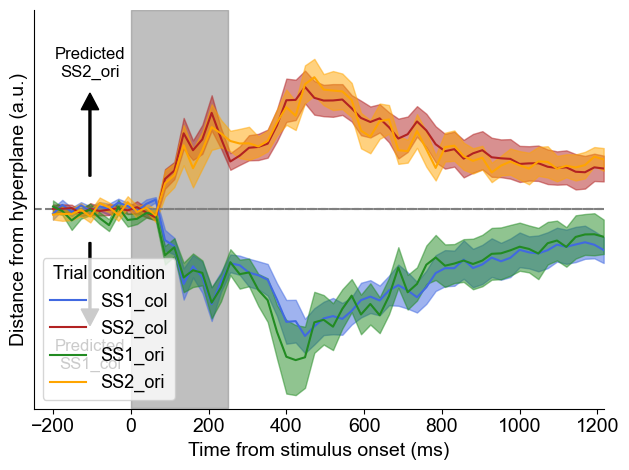

no significant differences between conditions


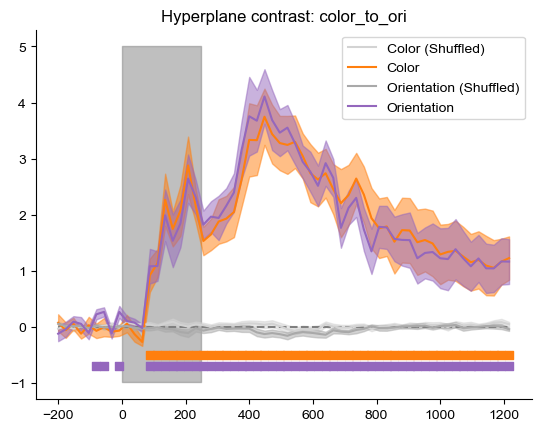

2.0889238867356 1.4800504037088056
2.0955007293944927 1.139620647953845


In [11]:
cond1_diff_eeg, cond2_diff_eeg = interpret_results('color_to_ori', ['Color', 'Orientation'], condition_order=[0,1], ylim=[-1, 5])

cond1_sub_delay_contrasts = cond1_diff_eeg.mean(2)[:, interp.t > 250].mean(1)
print(cond1_sub_delay_contrasts.mean(), cond1_sub_delay_contrasts.std())

cond2_sub_delay_contrasts = cond2_diff_eeg.mean(2)[:, interp.t > 250].mean(1)
print(cond2_sub_delay_contrasts.mean(), cond2_sub_delay_contrasts.std())


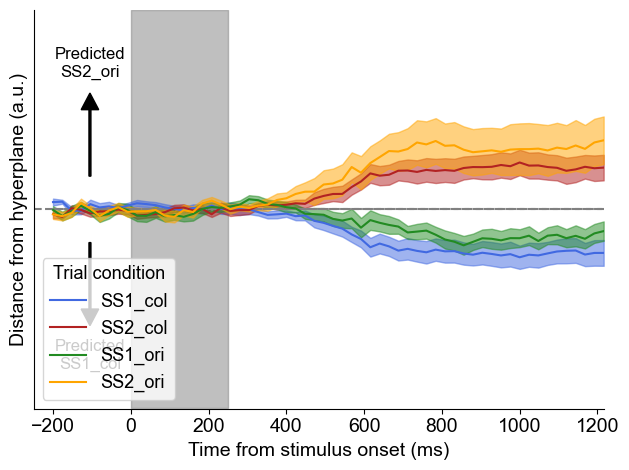

no significant differences between conditions


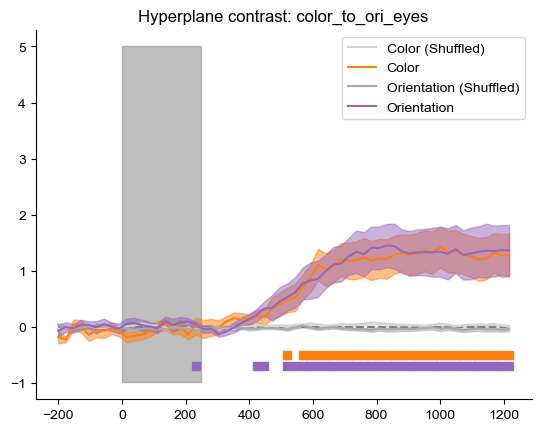

In [12]:
cond1_diff_eyes, cond2_diff_eyes = interpret_results('color_to_ori_eyes', ['Color', 'Orientation'], condition_order=[0,1], ylim=[-1, 5])

no significant correlations for condition Color
0.004312938447036328 0.0043129117049495284
no significant correlations for condition Orientation
0.012614596213336599 0.012613927143943358


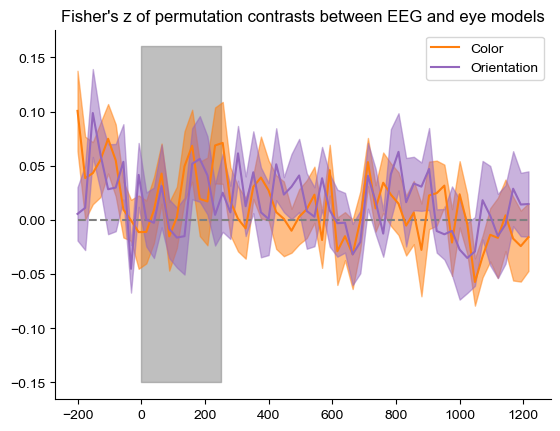

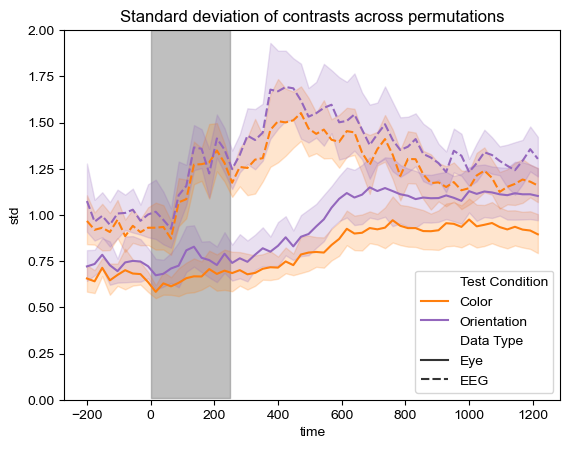

In [13]:
_ = correlate_contrasts(interp, [cond1_diff_eyes, cond2_diff_eyes], [cond1_diff_eeg, cond2_diff_eeg], ['Color', 'Orientation'], 'color_to_ori', ylim=[-.16, .16])

# 2. Orientation to Color

In [14]:
bad_eye_subs = train_model_on_subset(['SS1_ori', 'SS2_ori'], 'ori_to_color')
bad_eye_subs

[]

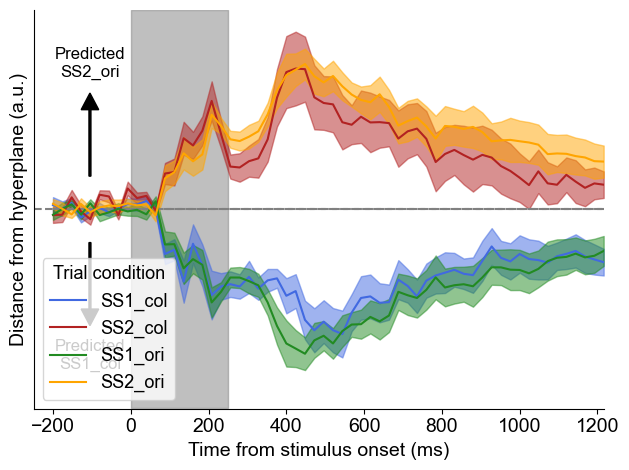

no significant differences between conditions


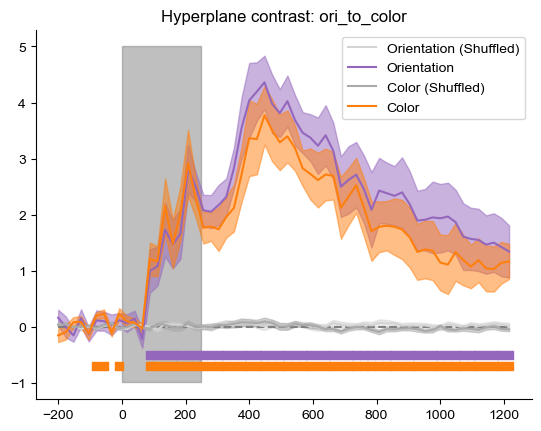

In [15]:
cond1_diff_eeg, cond2_diff_eeg = interpret_results('ori_to_color', ['Color', 'Orientation'], condition_order=[1,0],  ylim=[-1, 5])

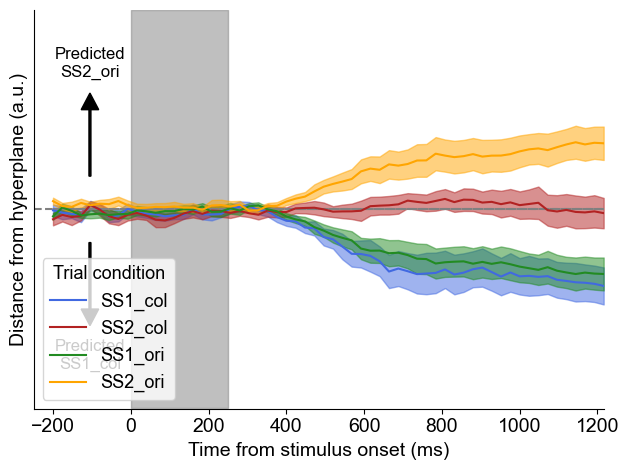

no significant differences between conditions


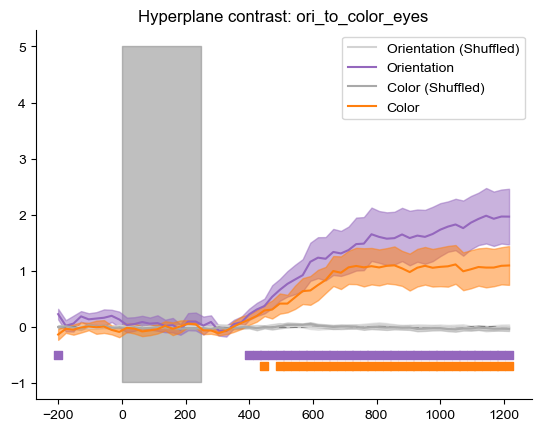

In [16]:
cond1_diff_eyes, cond2_diff_eyes = interpret_results('ori_to_color_eyes', ['Color', 'Orientation'], condition_order=[1,0],  ylim=[-1, 5])

no significant correlations for condition Orientation
-0.004102399979534486 -0.00410237696565547
0.011960890679023601 0.011960320325069869


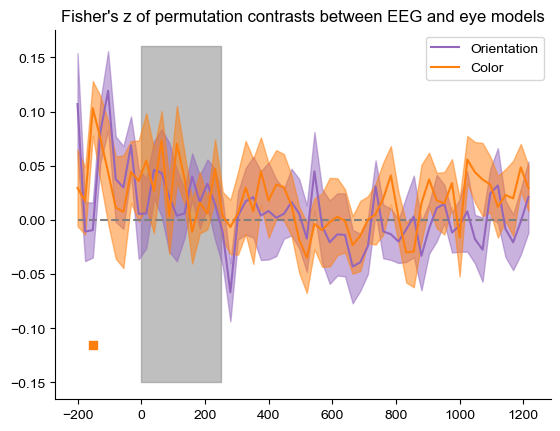

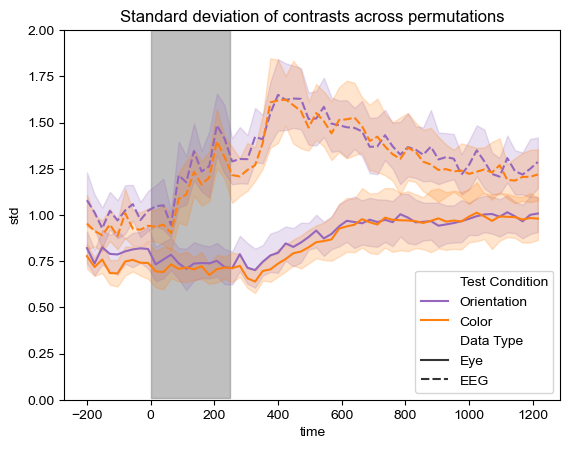

In [21]:
_ = correlate_contrasts(interp, [cond1_diff_eyes, cond2_diff_eyes], [cond1_diff_eeg, cond2_diff_eeg], ['Orientation', 'Color'], 'ori_to_color', ylim=[-.16, .16])